**<h2> MBTI Personality Prediction using Machine Learning : CSL2050 </h2>**
<hr>

By :<br>
Vedant A. Sontake<br> 
Electrical Engineering, B.Tech.<br> 
Indian Institute of Technology Jodhpur



In [6]:
import pandas as pd
import numpy as np
import nltk
import re
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer,TfidfTransformer
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV

In [7]:
mbti_df=pd.read_csv('./train_data.csv')

In [8]:
mbti_df.head()

,type,posts
0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...
1,ENTP,'I'm finding the lack of me in these posts ver...
2,INTP,'Good one _____ https://www.youtube.com/wat...
3,INTJ,"'Dear INTP, I enjoyed our conversation the o..."
4,ENTJ,'You're fired.|||That's another silly misconce...


In [9]:
mbti_df.posts[0]

"'http://www.youtube.com/watch?v=qsXHcwe3krw|||http://41.media.tumblr.com/tumblr_lfouy03PMA1qa1rooo1_500.jpg|||enfp and intj moments  https://www.youtube.com/watch?v=iz7lE1g4XM4  sportscenter not top ten plays  https://www.youtube.com/watch?v=uCdfze1etec  pranks|||What has been the most life-changing experience in your life?|||http://www.youtube.com/watch?v=vXZeYwwRDw8   http://www.youtube.com/watch?v=u8ejam5DP3E  On repeat for most of today.|||May the PerC Experience immerse you.|||The last thing my INFJ friend posted on his facebook before committing suicide the next day. Rest in peace~   http://vimeo.com/22842206|||Hello ENFJ7. Sorry to hear of your distress. It's only natural for a relationship to not be perfection all the time in every moment of existence. Try to figure the hard times as times of growth, as...|||84389  84390  http://wallpaperpassion.com/upload/23700/friendship-boy-and-girl-wallpaper.jpg  http://assets.dornob.com/wp-content/uploads/2010/04/round-home-design.jpg ...

In [10]:
mbti_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8675 entries, 0 to 8674
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   type    8675 non-null   object
 1   posts   8675 non-null   object
dtypes: object(2)
memory usage: 135.7+ KB


## Data Visualization

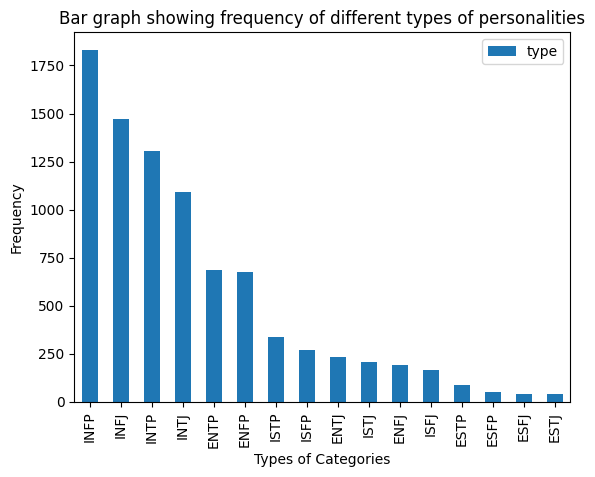

In [11]:
pd.DataFrame(mbti_df.type.value_counts()).plot.bar()
plt.ylabel('Frequency')
plt.xlabel('Types of Categories')
plt.title('Bar graph showing frequency of different types of personalities')
plt.show()

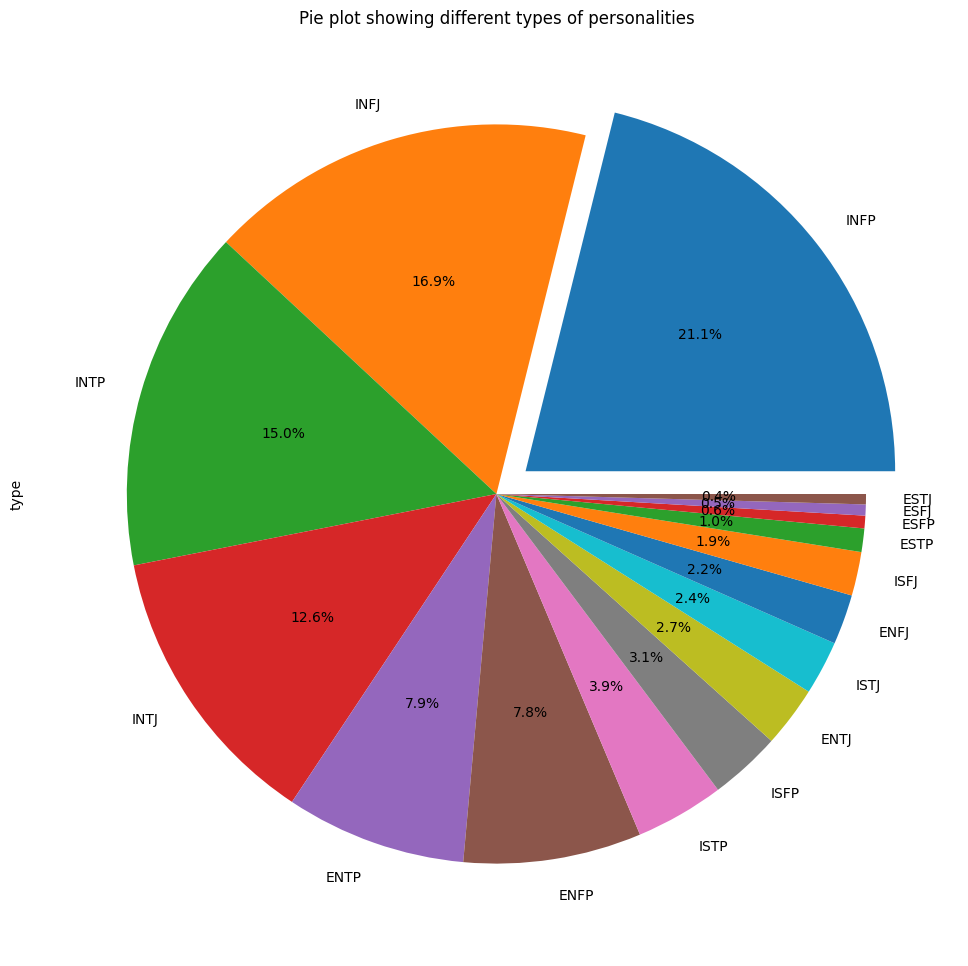

In [12]:
mbti_df.type.value_counts().plot(kind='pie',figsize=(12,12), autopct='%1.1f%%', explode=[0.1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0])
plt.title('Pie plot showing different types of personalities')
plt.show()

/tmp/ipykernel_62924/70030955.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(mbti_df["posts"].apply(len))


Text(0.5, 1.0, 'Distribution of lengths of the post')

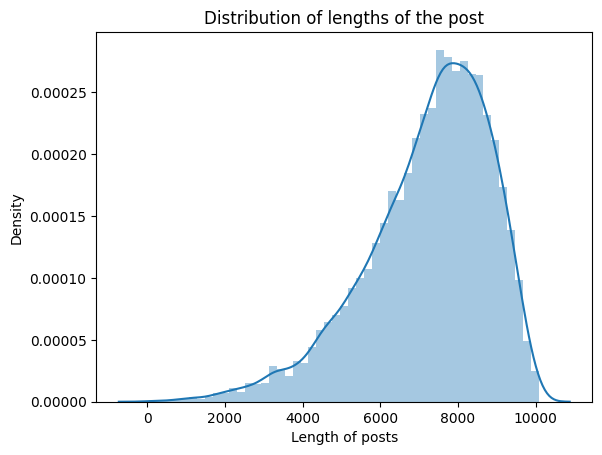

In [13]:
sns.distplot(mbti_df["posts"].apply(len))
plt.xlabel("Length of posts")
plt.ylabel("Density")
plt.title("Distribution of lengths of the post")

##Preprocessing of Dataset

In [14]:
mbti_df["posts"] = mbti_df["posts"].str.lower()       #converts text in posts to lowercase as it is preferred in nlp

In [15]:
for i in range(len(mbti_df)):
  post_temp=mbti_df._get_value(i, 'posts')
  pattern = re.compile(r'https?://[a-zA-Z0-9./-]*/[a-zA-Z0-9?=_.]*[_0-9.a-zA-Z/-]*')    #to match url links present in the post
  post_temp= re.sub(pattern, ' ', post_temp)                                            #to replace that url link with space
  mbti_df._set_value(i, 'posts',post_temp)

In [16]:
for i in range(len(mbti_df)):
  post_temp=mbti_df._get_value(i, 'posts')
  pattern = re.compile(r'[0-9]')                                    #to match numbers from 0 to 9
  post_temp= re.sub(pattern, ' ', post_temp)                        #to replace them with space
  pattern = re.compile('\W+')                                       #to match alphanumeric characters
  post_temp= re.sub(pattern, ' ', post_temp)                        #to replace them with space
  pattern = re.compile(r'[_+]')
  post_temp= re.sub(pattern, ' ', post_temp)
  mbti_df._set_value(i, 'posts',post_temp)

In [17]:
for i in range(len(mbti_df)):
  post_temp=mbti_df._get_value(i, 'posts')
  pattern = re.compile('\s+')                                     #to match multiple whitespaces
  post_temp= re.sub(pattern, ' ', post_temp)                      #to replace them with single whitespace
  mbti_df._set_value(i, 'posts', post_temp)

In [18]:
from nltk.corpus import stopwords
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/shambhavi/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [19]:
remove_words = stopwords.words("english")
for i in range(mbti_df.shape[0]):
  post_temp=mbti_df._get_value(i, 'posts')
  post_temp=" ".join([w for w in post_temp.split(' ') if w not in remove_words])    #to remove stopwords
  mbti_df._set_value(i, 'posts', post_temp)

In [20]:
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     /home/shambhavi/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [21]:
for i in range(mbti_df.shape[0]):
  post_temp=mbti_df._get_value(i, 'posts')
  post_temp=" ".join([lemmatizer.lemmatize(w) for w in post_temp.split(' ')])   #to implement lemmetization i.e. to group together different forms of a word
  mbti_df._set_value(i, 'posts', post_temp)

In [22]:
print(mbti_df)

      type                                              posts
0     INFJ   enfp intj moment sportscenter top ten play pr...
1     ENTP   finding lack post alarming sex boring positio...
2     INTP   good one course say know blessing curse absol...
3     INTJ   dear intp enjoyed conversation day esoteric g...
4     ENTJ   fired another silly misconception approaching...
...    ...                                                ...
8670  ISFP   ixfp always think cat fi doms reason especial...
8671  ENFP   thread already exists someplace else post hec...
8672  INTP   many question thing would take purple pill pi...
8673  INFP   conflicted right come wanting child honestly ...
8674  INFP   long since personalitycafe although seem chan...

[8675 rows x 2 columns]


In [23]:
from sklearn.model_selection import train_test_split
train_data,test_data=train_test_split(mbti_df,test_size=0.2,random_state=42,stratify=mbti_df.type)

In [24]:
print(test_data)

      type                                              posts
7814  INFP   macona depends big family extroverted people ...
2233  ENFJ   blodsmak sveltihel brilliant episode regenera...
7261  INFJ   heylena lol compliment accepted thank jeesh f...
7794  INFJ   pac right rocket coffin like packed warhead r...
2950  INTJ   title thread misleading mention world dominat...
...    ...                                                ...
2006  INTJ   one sentence restrictive accurately portray d...
7137  ISTJ   wanted like odd hybrid dr james wilson house ...
6091  ENTP   took cognitive process test got cognitive pro...
2997  INFJ   get caught fantacy relationship better forget...
5458  ENTJ   doll love movie listed make think tritype one...

[1735 rows x 2 columns]


In [25]:
vectorizer=TfidfVectorizer( max_features=5000,stop_words='english')
vectorizer.fit(train_data.posts)
train_post=vectorizer.transform(train_data.posts).toarray()
test_post=vectorizer.transform(test_data.posts).toarray()
print(test_data.posts)

7814     macona depends big family extroverted people ...
2233     blodsmak sveltihel brilliant episode regenera...
7261     heylena lol compliment accepted thank jeesh f...
7794     pac right rocket coffin like packed warhead r...
2950     title thread misleading mention world dominat...
                              ...                        
2006     one sentence restrictive accurately portray d...
7137     wanted like odd hybrid dr james wilson house ...
6091     took cognitive process test got cognitive pro...
2997     get caught fantacy relationship better forget...
5458     doll love movie listed make think tritype one...
Name: posts, Length: 1735, dtype: object


In [26]:
from sklearn.preprocessing import LabelEncoder
target_encoder=LabelEncoder()
train_target=target_encoder.fit_transform(train_data.type)
test_target=target_encoder.fit_transform(test_data.type)

##Training different models and testing their performance

###Gaussian Naive Bayes

In [27]:
from sklearn.naive_bayes import GaussianNB

In [28]:
model_gnb=GaussianNB()
model_gnb.fit(train_post,train_target)
pred_gnb=model_gnb.predict(test_post)

In [29]:
pred_training_gnb=model_gnb.predict(train_post)

KeyboardInterrupt: 

In [ ]:
print("The train accuracy score for model trained on Gaussian Naive Bayes Classifier is:",accuracy_score(train_target,pred_training_gnb))

The train accuracy score for model trained on Gaussian Naive Bayes Classifier is: 0.6785302593659942


In [ ]:
print("The test acccuracy score for model trained on Gaussian Naive Bayes Classifier is:",accuracy_score(test_target,pred_gnb))

The test acccuracy score for model trained on Gaussian Naive Bayes Classifier is: 0.2639769452449568


In [ ]:
from sklearn.metrics import classification_report
personality_types=target_encoder.inverse_transform([i for i in range(16)])
print('Test classification report of Gaussian Naive Bayes\n',classification_report(test_target,model_gnb.predict(test_post),target_names=personality_types))

/home/rayaankhan2003/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/rayaankhan2003/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/rayaankhan2003/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test classification report of Gaussian Naive Bayes
               precision    recall  f1-score   support

        ENFJ       0.09      0.05      0.07        38
        ENFP       0.21      0.24      0.22       135
        ENTJ       0.01      0.02      0.02        46
        ENTP       0.24      0.20      0.22       137
        ESFJ       0.00      0.00      0.00         9
        ESFP       0.00      0.00      0.00        10
        ESTJ       0.00      0.00      0.00         8
        ESTP       0.00      0.00      0.00        18
        INFJ       0.35      0.29      0.32       294
        INFP       0.44      0.34      0.39       366
        INTJ       0.28      0.30      0.29       218
        INTP       0.36      0.32      0.34       261
        ISFJ       0.00      0.00      0.00        33
        ISFP       0.08      0.15      0.11        54
        ISTJ       0.18      0.15      0.16        41
        ISTP       0.09      0.27      0.13        67

    accuracy                

###Multinomial Naive Bayes

In [ ]:
from sklearn.naive_bayes import MultinomialNB

In [ ]:
model_mnb=MultinomialNB()
model_mnb.fit(train_post,train_target)
pred_mnb=model_mnb.predict(test_post)

In [ ]:
pred_training_mnb=model_mnb.predict(train_post)

In [ ]:
print("The train accuracy score for model trained on Multinomial Naive Bayes Classifier is:",accuracy_score(train_target,pred_training_mnb))

The train accuracy score for model trained on Multinomial Naive Bayes Classifier is: 0.4609510086455331


In [ ]:
print("The test acccuracy score for model trained on Multinomial Naive Bayes Classifier is:",accuracy_score(test_target,pred_mnb))

The test acccuracy score for model trained on Multinomial Naive Bayes Classifier is: 0.3804034582132565


In [ ]:
from sklearn.metrics import classification_report
personality_types=target_encoder.inverse_transform([i for i in range(16)])
print('Test classification report of Multinomial Naive Bayes \n',classification_report(test_target,model_mnb.predict(test_post),target_names=personality_types))

Test classification report of Multinomial Naive Bayes 
               precision    recall  f1-score   support

        ENFJ       0.00      0.00      0.00        38
        ENFP       1.00      0.01      0.01       135
        ENTJ       0.00      0.00      0.00        46
        ENTP       0.75      0.02      0.04       137
        ESFJ       0.00      0.00      0.00         9
        ESFP       0.00      0.00      0.00        10
        ESTJ       0.00      0.00      0.00         8
        ESTP       0.00      0.00      0.00        18
        INFJ       0.37      0.44      0.40       294
        INFP       0.32      0.91      0.47       366
        INTJ       0.70      0.21      0.32       218
        INTP       0.54      0.56      0.55       261
        ISFJ       0.00      0.00      0.00        33
        ISFP       0.00      0.00      0.00        54
        ISTJ       0.00      0.00      0.00        41
        ISTP       0.00      0.00      0.00        67

    accuracy            

/home/rayaankhan2003/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/rayaankhan2003/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/rayaankhan2003/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


###Random Forest Classifier

In [ ]:
from sklearn.ensemble import RandomForestClassifier

In [ ]:
model_rfc=RandomForestClassifier()
model_rfc.fit(train_post,train_target)
pred_rfc=model_rfc.predict(test_post)

In [ ]:
pred_training_rfc=model_rfc.predict(train_post)

In [ ]:
print("The train accuracy score for model trained on Random Forest Classifier is:",accuracy_score(train_target,pred_training_rfc))

The train accuracy score for model trained on Random Forest Classifier is: 1.0


In [ ]:
print("The test acccuracy score for model trained on Random Forest Classifier is:",accuracy_score(test_target,pred_rfc))

The test acccuracy score for model trained on Random Forest Classifier is: 0.5567723342939481


In [ ]:
from sklearn.metrics import classification_report
personality_types=target_encoder.inverse_transform([i for i in range(16)])
print('Test classification report of Random Forest Classifier\n',classification_report(test_target,model_rfc.predict(test_post),target_names=personality_types))

Test classification report of Random Forest Classifier
               precision    recall  f1-score   support

        ENFJ       1.00      0.03      0.05        38
        ENFP       0.77      0.38      0.51       135
        ENTJ       0.83      0.11      0.19        46
        ENTP       0.66      0.46      0.54       137
        ESFJ       0.00      0.00      0.00         9
        ESFP       0.00      0.00      0.00        10
        ESTJ       0.00      0.00      0.00         8
        ESTP       0.00      0.00      0.00        18
        INFJ       0.54      0.69      0.61       294
        INFP       0.47      0.86      0.61       366
        INTJ       0.63      0.50      0.56       218
        INTP       0.60      0.74      0.66       261
        ISFJ       0.00      0.00      0.00        33
        ISFP       1.00      0.11      0.20        54
        ISTJ       1.00      0.05      0.09        41
        ISTP       0.79      0.28      0.42        67

    accuracy            

/home/rayaankhan2003/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/rayaankhan2003/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/rayaankhan2003/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


###XGBoost Classifier

In [30]:
from xgboost import XGBClassifier
model_xgb=XGBClassifier()
model_xgb.fit(train_post,train_target)
pred_xgb=model_xgb.predict(test_post)

In [ ]:
pred_training_xgb=model_xgb.predict(train_post)

In [ ]:
print("The train accuracy score for model trained on XGBoost Classifier is:",accuracy_score(train_target,pred_training_xgb))

The train accuracy score for model trained on XGBoost Classifier is: 1.0


In [ ]:
print("The test accuracy score for model trained on XGBoost classifier is:",accuracy_score(test_target,pred_xgb))

The test accuracy score for model trained on XGBoost classifier is: 0.6605187319884727


In [ ]:
from sklearn.metrics import classification_report
personality_types=target_encoder.inverse_transform([i for i in range(16)])
print('Test classification report of XGBoost Classifier\n',classification_report(test_target,model_xgb.predict(test_post),target_names=personality_types))

Test classification report of XGBoost Classifier
               precision    recall  f1-score   support

        ENFJ       0.59      0.42      0.49        38
        ENFP       0.68      0.59      0.63       135
        ENTJ       0.68      0.41      0.51        46
        ENTP       0.62      0.61      0.62       137
        ESFJ       1.00      0.11      0.20         9
        ESFP       0.00      0.00      0.00        10
        ESTJ       1.00      0.38      0.55         8
        ESTP       0.44      0.22      0.30        18
        INFJ       0.68      0.73      0.71       294
        INFP       0.65      0.79      0.71       366
        INTJ       0.62      0.64      0.63       218
        INTP       0.72      0.79      0.75       261
        ISFJ       0.59      0.52      0.55        33
        ISFP       0.64      0.39      0.48        54
        ISTJ       0.60      0.37      0.45        41
        ISTP       0.65      0.55      0.60        67

    accuracy                  

/opt/homebrew/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


###LightGBM Classifier

In [ ]:
from lightgbm import LGBMClassifier as lgb
model_lgb = lgb()
model_lgb.fit(train_post,train_target)
pred_lgb=model_lgb.predict(test_post)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.447228 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 472063
[LightGBM] [Info] Number of data points in the train set: 6940, number of used features: 4999
[LightGBM] [Info] Start training from score -3.821177
[LightGBM] [Info] Start training from score -2.553488
[LightGBM] [Info] Start training from score -3.624701
[LightGBM] [Info] Start training from score -2.538782
[LightGBM] [Info] Start training from score -5.348549
[LightGBM] [Info] Start training from score -5.207471
[LightGBM] [Info] Start training from score -5.411070
[LightGBM] [Info] Start training from score -4.582377
[LightGBM] [Info] Start training from score -1.775183
[LightGBM] [Info] Start training from score -1.554764
[LightGBM] [Info] Start training from score -2.073121
[LightGBM] [Info] Start training from score -1.895201
[LightGBM] [Info] Start training from score -3.954708
[Light

In [ ]:
pred_training_lgb=model_lgb.predict(train_post)

In [ ]:
print("The train accuracy score for model trained on LightGBM Classifier is:",accuracy_score(train_target,pred_training_lgb))

The train accuracy score for model trained on LightGBM Classifier is: 1.0


In [ ]:
print("The test accuracy score for model trained on LightGBM classifier is:",accuracy_score(test_target,pred_lgb))

The test accuracy score for model trained on LightGBM classifier is: 0.6737752161383286


In [ ]:
from sklearn.metrics import classification_report
personality_types=target_encoder.inverse_transform([i for i in range(16)])
print('Test classification report of LightGBM Classifier\n',classification_report(test_target,model_lgb.predict(test_post),target_names=personality_types))

Test classification report of LightGBM Classifier
               precision    recall  f1-score   support

        ENFJ       0.70      0.42      0.52        38
        ENFP       0.71      0.64      0.67       135
        ENTJ       0.71      0.33      0.45        46
        ENTP       0.62      0.61      0.62       137
        ESFJ       0.00      0.00      0.00         9
        ESFP       0.00      0.00      0.00        10
        ESTJ       0.00      0.00      0.00         8
        ESTP       0.50      0.22      0.31        18
        INFJ       0.69      0.75      0.72       294
        INFP       0.65      0.81      0.72       366
        INTJ       0.68      0.66      0.67       218
        INTP       0.67      0.78      0.72       261
        ISFJ       0.76      0.48      0.59        33
        ISFP       0.78      0.46      0.58        54
        ISTJ       0.75      0.44      0.55        41
        ISTP       0.69      0.57      0.62        67

    accuracy                 

/home/rayaankhan2003/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/rayaankhan2003/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/rayaankhan2003/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


###Support Vector Classifier

In [ ]:
from sklearn.svm import SVC

In [ ]:
model_svc=SVC()
model_svc.fit(train_post,train_target)
pred_svc=model_svc.predict(test_post)

In [ ]:
pred_training_svc=model_svc.predict(train_post)

In [ ]:
print("The train accuracy score for model trained on Support Classifier is:",accuracy_score(train_target,pred_training_svc))

The train accuracy score for model trained on Support Classifier is: 0.950864553314121


In [ ]:
print("The test accuracy score for model trained on Support Vector classifier is:",accuracy_score(test_target,pred_svc))

The test accuracy score for model trained on Support Vector classifier is: 0.6530259365994237


In [ ]:
from sklearn.metrics import classification_report
personality_types=target_encoder.inverse_transform([i for i in range(16)])
print('Test classification report of Support Vector Machine\n',classification_report(test_target,model_svc.predict(test_post),target_names=personality_types))

Test classification report of Support Vector Machine
               precision    recall  f1-score   support

        ENFJ       0.67      0.26      0.38        38
        ENFP       0.77      0.59      0.66       135
        ENTJ       0.76      0.28      0.41        46
        ENTP       0.68      0.52      0.59       137
        ESFJ       0.33      0.11      0.17         9
        ESFP       0.00      0.00      0.00        10
        ESTJ       0.00      0.00      0.00         8
        ESTP       0.83      0.28      0.42        18
        INFJ       0.67      0.69      0.68       294
        INFP       0.60      0.86      0.70       366
        INTJ       0.65      0.64      0.64       218
        INTP       0.65      0.83      0.73       261
        ISFJ       0.83      0.30      0.44        33
        ISFP       0.78      0.33      0.47        54
        ISTJ       0.75      0.29      0.42        41
        ISTP       0.76      0.57      0.65        67

    accuracy              

/home/rayaankhan2003/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/rayaankhan2003/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/rayaankhan2003/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


###Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression

In [ ]:
model_lr=LogisticRegression()
model_lr.fit(train_post,train_target)
pred_lr=model_lr.predict(test_post)

/home/rayaankhan2003/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [ ]:
pred_training_lr=model_lr.predict(train_post)

In [ ]:
print("The train accuracy score for model trained on Logistic Regression is:",accuracy_score(train_target,pred_training_lr))

The train accuracy score for model trained on Logistic Regression is: 0.7951008645533141


In [ ]:
print("The test accuracy score for model trained on Logistic Regression is:",accuracy_score(test_target,pred_lr))

The test accuracy score for model trained on Logistic Regression is: 0.6495677233429394


In [ ]:
from sklearn.metrics import classification_report
personality_types=target_encoder.inverse_transform([i for i in range(16)])
print('Test classification report of Logistic Regression\n',classification_report(test_target,model_lr.predict(test_post),target_names=personality_types))

Test classification report of Logistic Regression
               precision    recall  f1-score   support

        ENFJ       0.64      0.18      0.29        38
        ENFP       0.76      0.59      0.67       135
        ENTJ       0.60      0.26      0.36        46
        ENTP       0.66      0.53      0.59       137
        ESFJ       1.00      0.11      0.20         9
        ESFP       0.00      0.00      0.00        10
        ESTJ       0.00      0.00      0.00         8
        ESTP       1.00      0.11      0.20        18
        INFJ       0.65      0.71      0.68       294
        INFP       0.60      0.86      0.71       366
        INTJ       0.62      0.67      0.64       218
        INTP       0.69      0.84      0.75       261
        ISFJ       0.67      0.18      0.29        33
        ISFP       0.80      0.30      0.43        54
        ISTJ       0.75      0.22      0.34        41
        ISTP       0.69      0.52      0.59        67

    accuracy                 

/home/rayaankhan2003/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/rayaankhan2003/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/rayaankhan2003/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


###Results

In [ ]:
result_df=pd.DataFrame({'Model':["Gaussian NB","Multinomial NB","Random Forest","XGBoost","LightGBM","SVM","Logistic Regresssion"],
                        'Accuracy':[accuracy_score(test_target,pred_gnb),accuracy_score(test_target,pred_mnb),accuracy_score(test_target,pred_rfc),accuracy_score(test_target,pred_xgb),accuracy_score(test_target,pred_lgb),accuracy_score(test_target,pred_svc),accuracy_score(test_target,pred_lr)]})

NameError: name 'pd' is not defined

In [ ]:
print(result_df.sort_values(by = 'Accuracy'))

                  Model  Accuracy
0           Gaussian NB  0.263977
1        Multinomial NB  0.380403
2         Random Forest  0.556772
6  Logistic Regresssion  0.649568
5                   SVM  0.653026
3               XGBoost  0.671470
4              LightGBM  0.673775


In [ ]:
tests=pd.read_csv('tweets.csv')
# tests=tests[0]
tests['text'] = tests['text'].str.lower()       #converts text in posts to lowercase as it is preferred in nlp
# print(tests)
tests=np.array(tests)
t=""
for tes in tests:
    t+=tes

tests=pd.read_csv('linkedin.csv')
tests=tests.columns
tests=np.array(tests)
tests=pd.DataFrame(tests)
tests[0] = tests[0].str.lower()
tests=np.array(tests)
for tes in tests:
    t+=tes
print(t)
tests=pd.DataFrame(t)
print(tests)


['still my favorite explanation of the scientific method.ph.d. admissions at iiit hyderabad are open for winter 2023. the ph.d. program provides access to our vibrant research curriculum in the core areas of cse and ece. details at https://pgadmissions.iiit.ac.in/pg_wree/i just pushed my color-coded latex table script to github: https://github.com/jonbarron/tabilize/blob/main/tabilize.ipynb… every table i\'ve made since grad school has been procedurally generated. i *highly* recommend doing this --- if you copy-paste and manually-bold numbers, you will eventually make a costly mistake.suggested language for the paper in a hyped field: "last year we shifted the paradigm three times [ref 1-3], while others reported only incremental paradigm shifts. in this work, we present a much larger, disruptive paradigm shift, or, if you wish, a paradigm giant leap. ... this…senior academics exclusively citing other senior academicspeak bangalore!when it\'s your turn to do lab meeting and you don\'t 

In [ ]:

for i in range(len(tests)):
  post_temp=tests._get_value(i, 0)
  pattern = re.compile(r'https?://[a-zA-Z0-9./-]*/[a-zA-Z0-9?=_.]*[_0-9.a-zA-Z/-]*')    #to match url links present in the post
  post_temp= re.sub(pattern, ' ', post_temp)                                            #to replace that url link with space
  tests._set_value(i, 0,post_temp)

for i in range(len(tests)):
  post_temp=tests._get_value(i, 0)
  pattern = re.compile(r'[0-9]')                                    #to match numbers from 0 to 9
  post_temp= re.sub(pattern, ' ', post_temp)                        #to replace them with space
  pattern = re.compile('\W+')                                       #to match alphanumeric characters
  post_temp= re.sub(pattern, ' ', post_temp)                        #to replace them with space
  pattern = re.compile(r'[_+]')
  post_temp= re.sub(pattern, ' ', post_temp)
  tests._set_value(i, 0,post_temp)

for i in range(len(tests)):
  post_temp=tests._get_value(i, 0)
  pattern = re.compile('\s+')                                     #to match multiple whitespaces
  post_temp= re.sub(pattern, ' ', post_temp)                      #to replace them with single whitespace
  tests._set_value(i, 0, post_temp)

remove_words = stopwords.words("english")
for i in range(tests.shape[0]):
  post_temp=tests._get_value(i, 0)
  post_temp=" ".join([w for w in post_temp.split(' ') if w not in remove_words])    #to remove stopwords
  tests._set_value(i, 0, post_temp)

for i in range(tests.shape[0]):
  post_temp=tests._get_value(i, 0)
  post_temp=" ".join([lemmatizer.lemmatize(w) for w in post_temp.split(' ')])   #to implement lemmetization i.e. to group together different forms of a word
  tests._set_value(i, 0, post_temp)

test_post=vectorizer.transform(tests[0]).toarray()
print(test_post)

pred_xgb=model_xgb.predict(test_post)
print(pred_xgb)
pred_xgb=np.sum(pred_xgb)/len(pred_xgb)
print(pred_xgb)



[[0. 0. 0. ... 0. 0. 0.]]
[8]
8.0


In [ ]:
personality=["ENFJ","ENFP","ENTJ","ENTP","ESFJ","ESFP","ESTJ","ESTP","INFJ","INFP","INTJ","INTP","ISFJ","ISFP","ISTJ","ISTP" ]      
print(personality[round(pred_xgb)])

INFJ


In [ ]:
# Get user input for MBTI type
user_mbti = personality[round[pred_xgb]]
# Convert the user input to uppercase for case-insensitive matching
user_mbti = user_mbti.upper()
# Initialize a variable to store the suggested job role
job_role = "Unknown"
# Use if-else conditions to suggest a job role based on the MBTI type
if user_mbti == "ISTJ":
    job_role = "Manager"
elif user_mbti in ["ISFJ", "INFJ"]:
    job_role = "Doctor"
elif user_mbti == "INTJ":
    job_role = "Engineer"
elif user_mbti == "ISTP":
    job_role = "Engineer"
elif user_mbti in ["ISFP", "INFP"]:
    job_role = "Artist"
elif user_mbti == "INTP":
    job_role = "Scientist"
elif user_mbti == "ESTP":
    job_role = "Salesperson"
elif user_mbti == "ESFP":
    job_role = "Entertainer"
elif user_mbti == "ENFP":
    job_role = "Teacher"
elif user_mbti == "ENTP":
    job_role = "Entrepreneur"
elif user_mbti == "ESTJ":
    job_role = "Manager"
elif user_mbti == "ESFJ":
    job_role = "Lawyer"
elif user_mbti == "ENFJ":
    job_role = "Teacher"
elif user_mbti == "ENTJ":
    job_role = "CEO"
print(job_role)

NameError: name 'personality' is not defined